# CNN Classifier for Plant Waves Using Spectrograms
----

#### PREPROCESSING: Create Spectrogram Images 
In this step, we compute the spectrogram, create spectrogram images, reshape it to 97x97 images, and store them to disk with labels corresponding to classes and the number of sample. 

In [28]:
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from scipy import signal
from PIL import Image
from tqdm import tqdm

%run ../src/utils/constants.py

Load raw data that has been split into train, test, and validation sets for the 81k and 191k cases.

In [15]:
path_to_pickle_train81k = DATASETS_DIR / "train-81k-stratified-without-neutral.pkl"
path_to_pickle_train191k = DATASETS_DIR / "train-191k-stratified-without-neutral.pkl"
path_to_pickle_test81k = DATASETS_DIR / "test-81k-stratified-without-neutral.pkl"
path_to_pickle_val81k = DATASETS_DIR / "val-81k-stratified-without-neutral.pkl"

In [16]:
with open(path_to_pickle_train81k, 'rb') as train_81k_file:
    train_81k = pickle.load(train_81k_file)

In [17]:
with open(path_to_pickle_train191k, 'rb') as train_191k_file:
    train_191k = pickle.load(train_191k_file)

In [18]:
with open(path_to_pickle_test81k, 'rb') as test_81k_file:
    test_81k = pickle.load(test_81k_file)

In [19]:
with open(path_to_pickle_val81k, 'rb') as val_81k_file:
    val_81k = pickle.load(val_81k_file)

While ignoring the class `Neutral`, separate wave slices and labels, and create a Tensor dataset. Adjust `for segment in train_191k` for creating a specific dataset - train, test, val. 

In [20]:
wav_slices = []
labels = []
for segment in train_81k:  # adjust this iterable for specific dataset.
    wav_slices.append(segment[0])
    labels.append(segment[1])

In [21]:
wav_slices = torch.tensor(np.array(wav_slices), dtype=torch.float32)
labels = torch.tensor(np.array(labels), dtype=torch.long)
dataset = TensorDataset(wav_slices, labels)
print(wav_slices)

tensor([[    7.,     9.,    10.,  ...,   -67.,   -67.,   -67.],
        [   44.,    47.,    51.,  ...,  -102.,  -100.,   -98.],
        [-2168., -2147., -2126.,  ...,  -712.,  -827.,  -943.],
        ...,
        [ 1042.,  1177.,  1312.,  ..., -1334., -1364., -1391.],
        [    7.,     3.,     0.,  ...,   197.,   197.,   196.],
        [  -37.,   -37.,   -37.,  ...,    72.,    72.,    72.]])


Normalize the samples using per-sample normalization.

In [22]:
data_tensor, labels_tensor = dataset.tensors
mean = torch.mean(data_tensor, dim=1, keepdim=True)
std_dev = torch.std(data_tensor, dim=1, keepdim=True)
standardized_data = (data_tensor - mean) / (std_dev + 0.00000001)  # smoothing term to prevent zero division

dataset = TensorDataset(standardized_data, labels_tensor)

Compute the spectrograms and save the plots to disk as `.png`. 

In [26]:
train_81k_folder = "train-81k"
train_191k_folder = "train-191k"  # for now, ignore this case.
test_81k_folder = "test-81k"
val_81k_folder = "val-81k"

In [27]:
if not os.path.exists(SPECTROGRAM_IMAGES_DIR / train_81k_folder):
    os.makedirs(SPECTROGRAM_IMAGES_DIR / train_81k_folder)

if not os.path.exists(SPECTROGRAM_IMAGES_DIR / test_81k_folder):
    os.makedirs(SPECTROGRAM_IMAGES_DIR / test_81k_folder)

if not os.path.exists(SPECTROGRAM_IMAGES_DIR / val_81k_folder):
    os.makedirs(SPECTROGRAM_IMAGES_DIR / val_81k_folder)

Adjust the `train_81k_folder` to save the created spectrograms.

100%|████████████████████████████████| 12130/12130 [00:00<00:00, 103968.98it/s]


(129, 44)


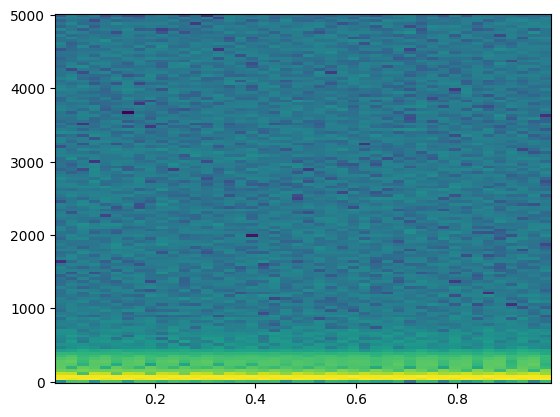

In [81]:
count = 0 
for wav_slice, label in tqdm(dataset):
    if count == 10000:    
        f, t, Sxx = signal.spectrogram(wav_slice, fs=SAMPLING_RATE)
        plt.pcolormesh(t, f, 10 * np.log10(Sxx))
        #plt.pcolormesh(t, f, Sxx)
        #plt.ylim([0, 4000])
        print(Sxx.shape)
    count += 1


100%|████████████████████████████████| 12130/12130 [00:00<00:00, 119870.57it/s]


(129, 44)


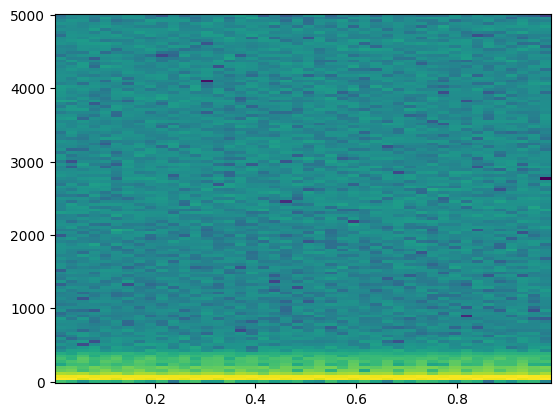

In [80]:
count = 0 
for wav_slice, label in tqdm(dataset):
    if count == 870:    
        f, t, Sxx = signal.spectrogram(wav_slice, fs=SAMPLING_RATE)
        plt.pcolormesh(t, f, 10 * np.log10(Sxx))
        #plt.pcolormesh(t, f, Sxx)
        #plt.ylim([0, 4000])
        print(Sxx.shape)
    count += 1


In [ ]:
count = 0 
for wav_slice, label in tqdm(dataset):
    mfcc_features = mfcc(wav_slice, samplerate=10000, winlen=0.025, winstep=0.010, numcep=26)

    file_name = f"{count}_mfcc_class_{label}.png"
    save_path = os.path.join(SPECTROGRAM_IMAGES_DIR / train_81k_folder, file_name)  # Adjust train_191k_folder

    if not os.path.exists(save_path):
        plt.imshow(mfcc_features)
        plt.axis("off")
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
    count += 1